# Language and contents
- Language analysis

- language switch group by model and statistical analysis

- toxic and PII data group by country analysis

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,desc,split,regexp_extract, row_number, when,explode, lag, sum, avg,count, lit
from pyspark.sql.window import Window

import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
# .config("local[*]") \

## language analysis

In [ ]:
# spark = SparkSession.builder \
#     .config("spark.executor.memory", "4g") \
#     .config("spark.driver.memory", "4g") \
#     .config("spark.hadoop.fs.defaultFS", "hdfs://s3505235@spark-head5.eemcs.utwente.nl") \
#     .getOrCreate()

In [2]:
path1 = "../data/WildChat-1M"
# path1 = "hdfs://spark-head5.eemcs.utwente.nl:/user/s3505235/WildChat-1M-Full"
path2 = "../data/lmsys-chat-1m"

df_wildchat = spark.read.parquet(path1)
df_lmsys = spark.read.parquet(path2)

# select the common columns
# columns_wildchat = set(df_wildchat.columns)
# columns_lmsys = set(df_lmsys.columns)
# common_columns = list(columns_wildchat.intersection(columns_lmsys))
# remove openai_moderation from common columns
# common_columns.remove('openai_moderation')
# print(common_columns)
df_wildchat_common = df_wildchat.select(["language", "turn"])
df_lmsys_common = df_lmsys.select(["language", "turn"])

# union the two dataframes
df = df_wildchat_common.unionByName(df_lmsys_common)


In [3]:
# anlyze the top 5 most common languages
language_counts = df.groupBy("language").count().orderBy(desc("count"))
k = 5
top_k_languages = language_counts.limit(k)
top_k_languages.show()

+--------+-------+
|language|  count|
+--------+-------+
| English|1255951|
| Chinese| 143801|
| Russian| 114723|
| Spanish|  44205|
|  French|  42116|
+--------+-------+



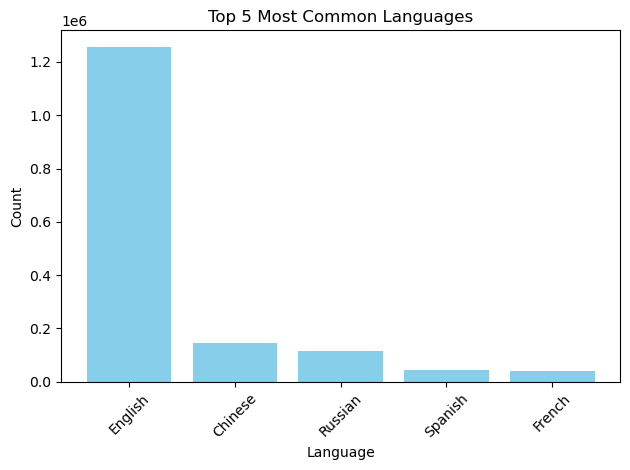

In [7]:
top_5_languages_pd = top_k_languages.toPandas()
plt.bar(top_5_languages_pd["language"], top_5_languages_pd["count"], color='skyblue')
plt.title("Top 5 Most Common Languages")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
df_wildchat = df_wildchat.withColumn('model_tag', regexp_extract('model', r'(gpt-\d(?:\.\d)?)', 1))

In [9]:
language_count = df_wildchat.groupBy("model_tag", "language").count().orderBy("count", ascending=False)

window_spec = Window.partitionBy("model_tag").orderBy(desc("count"))
top_language = language_count.withColumn("rank", row_number().over(window_spec)).filter(col("rank") <= 5)

top_language.show()

+---------+--------+------+----+
|model_tag|language| count|rank|
+---------+--------+------+----+
|  gpt-3.5| English|347813|   1|
|  gpt-3.5| Chinese|104735|   2|
|  gpt-3.5| Russian| 62168|   3|
|  gpt-3.5|  French| 19512|   4|
|  gpt-3.5|  German| 14300|   5|
|    gpt-4| English|130685|   1|
|    gpt-4| Russian| 24959|   2|
|    gpt-4| Chinese| 14567|   3|
|    gpt-4|  French|  7465|   4|
|    gpt-4| Spanish|  6175|   5|
+---------+--------+------+----+



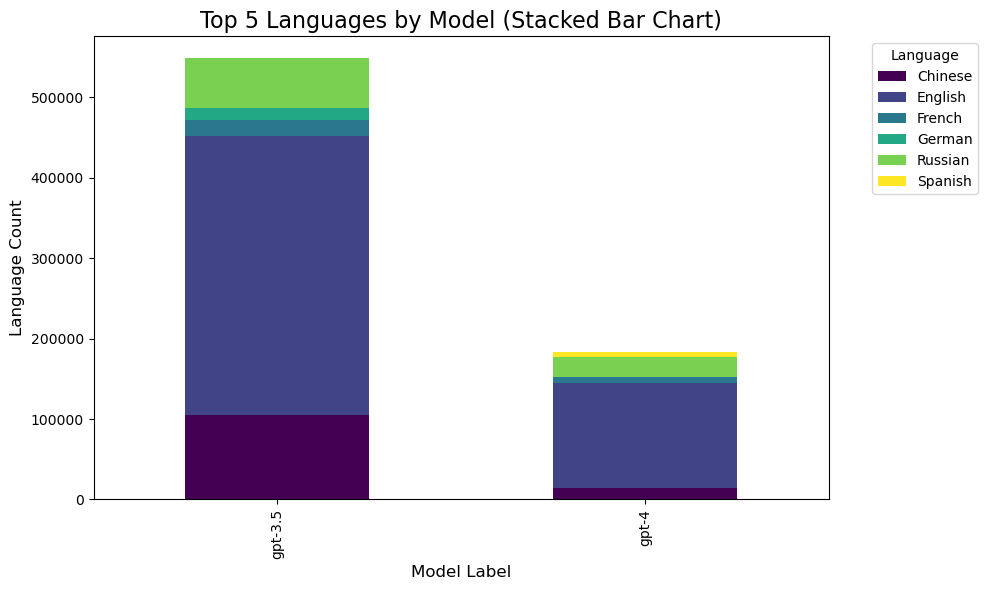

In [10]:
top_language_pd = top_language.toPandas()
# plot the top 5 languages

pivot_df = top_language_pd.pivot(index='model_tag', columns='language', values='count')
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Top 5 Languages by Model (Stacked Bar Chart)', fontsize=16)
plt.xlabel('Model Label', fontsize=12, )
plt.ylabel('Language Count', fontsize=12)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

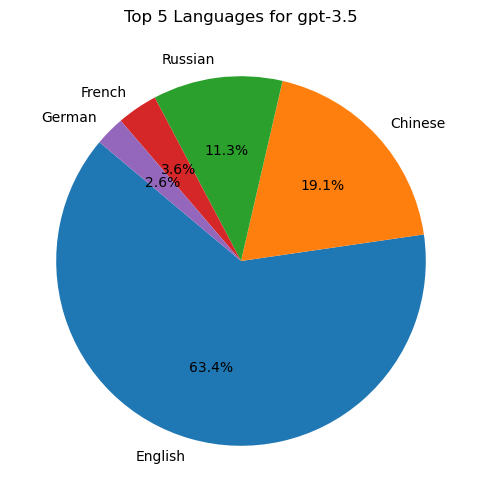

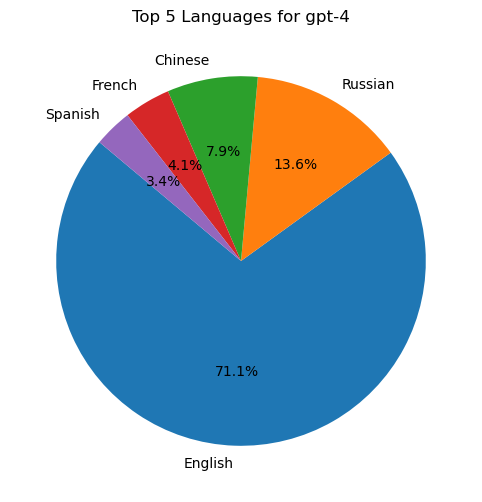

In [11]:
# draw pie chart for each model
model_tags = top_language_pd['model_tag'].unique()
for model in model_tags:
    model_data = top_language_pd[top_language_pd['model_tag'] == model]
    
    languages = model_data['language']
    counts = model_data['count']
    
    plt.figure(figsize=(8, 6))
    plt.pie(counts, labels=languages, autopct='%1.1f%%', startangle=140)
    plt.title(f"Top 5 Languages for {model}")
    plt.show()

In [12]:
country_count = df_wildchat.groupBy("country").count().sort(desc("count"))
top_country = country_count.limit(20)
top_country.show()

+---------------+------+
|        country| count|
+---------------+------+
|  United States|170520|
|         Russia|113881|
|          China|101156|
|      Hong Kong| 46955|
| United Kingdom| 30808|
|        Germany| 28975|
|         France| 26065|
|          Japan| 17567|
|          India| 16676|
|         Canada| 16389|
|          Egypt| 14310|
|      Singapore| 13401|
|         Taiwan| 11927|
|         Brazil| 11621|
|       DR Congo|  9874|
|    Philippines|  9293|
|        Türkiye|  9035|
|          Italy|  8432|
|The Netherlands|  8262|
|        Vietnam|  8184|
+---------------+------+



In [13]:
df_filtered = df_wildchat.filter(col("country").isin([
    "United States", "Russia", "China", "Hong Kong", "United Kingdom", 
    "Germany", "France", "Japan", "India", "Canada", 
    "Egypt", "Singapore", "Taiwan", "Brazil", "DR Congo", 
    "Philippines", "Türkiye", "Italy", "The Netherlands", "Vietnam"
]))
languages_to_keep = ["English", "Chinese", "Russian", "French", "Spanish", "German", "Dutch", "Japanese", "Portuguese"]
df_filtered = df_filtered.withColumn(
    "language",
    when(col("language").isin(languages_to_keep), col("language")).otherwise("others")
)

df_filtered = df_filtered.groupBy("country", "language").count().sort(desc("count"))
window_spec = Window.partitionBy("country").orderBy(desc("count"))
top_language = df_filtered.withColumn("rank", row_number().over(window_spec)).filter(col("rank") <= 5)
top_language.show(10)

+-------+----------+-----+----+
|country|  language|count|rank|
+-------+----------+-----+----+
| Brazil|Portuguese| 8797|   1|
| Brazil|   English| 1868|   2|
| Brazil|    others|  568|   3|
| Brazil|   Spanish|  158|   4|
| Brazil|  Japanese|  129|   5|
| Canada|   English|13830|   1|
| Canada|  Japanese|  679|   2|
| Canada|    others|  671|   3|
| Canada|   Chinese|  579|   4|
| Canada|    French|  463|   5|
+-------+----------+-----+----+
only showing top 10 rows



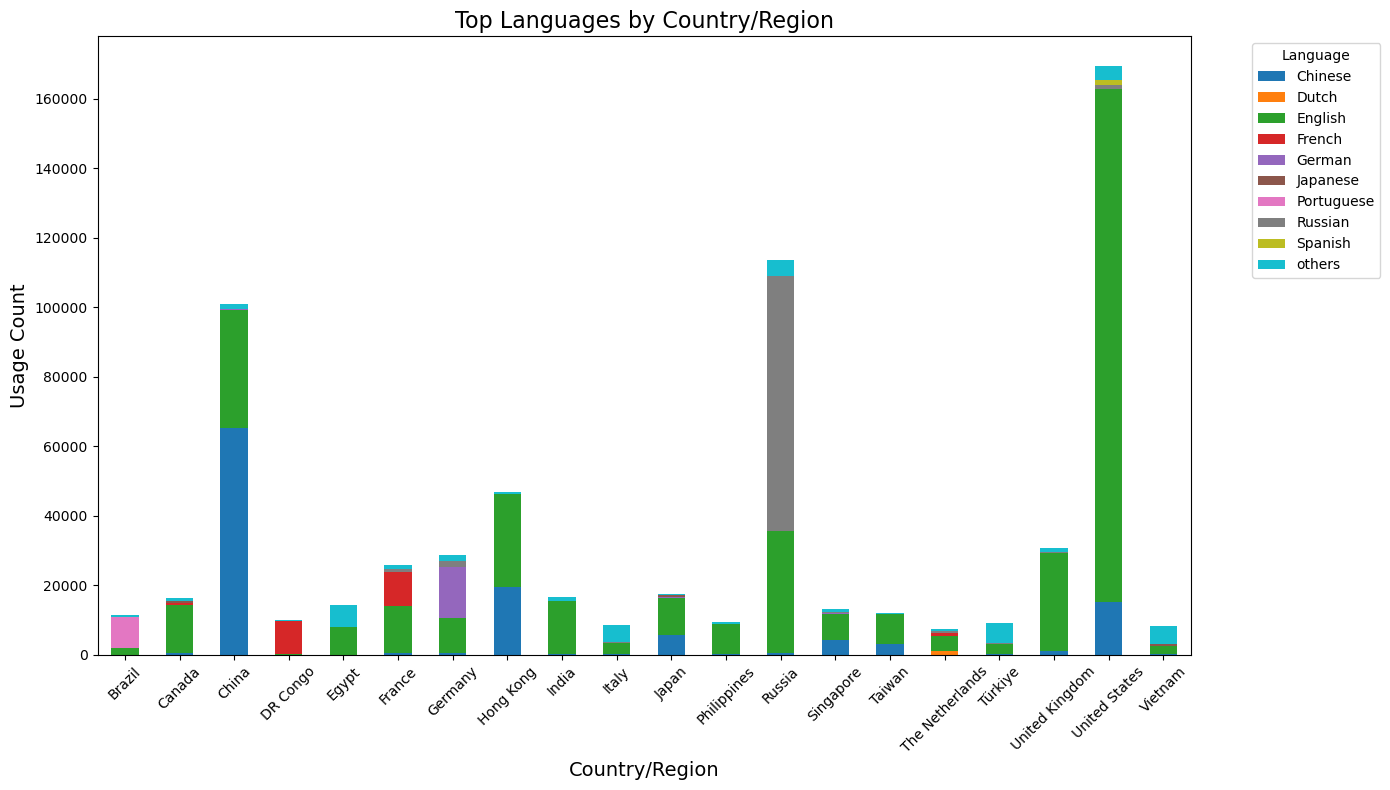

In [14]:
top_language_pd = top_language.toPandas()

# pivot columns plot ->
pivot_data = top_language_pd.pivot(index="country", columns="language", values="count")

pivot_data.plot(kind="bar", stacked=True, figsize=(14, 8))
plt.title("Top Languages by Country/Region", fontsize=16)
plt.xlabel("Country/Region", fontsize=14)
plt.ylabel("Usage Count", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import plotly.express as px

In [17]:
np.random.seed(42)

country_coords = {
    "United States": (37.0902, -95.7129),
    "Russia": (61.5240, 105.3188),
    "China": (35.8617, 104.1954),
    "Hong Kong": (22.3193, 114.1694),
    "United Kingdom": (55.3781, -3.4360),
    "Germany": (51.1657, 10.4515),
    "France": (46.6034, 1.8883),
    "Japan": (36.2048, 138.2529),
    "India": (20.5937, 78.9629),
    "Canada": (56.1304, -106.3468),
    "Egypt": (26.8206, 30.8025),
    "Singapore": (1.3521, 103.8198),
    "Taiwan": (23.6978, 120.9605),
    "Brazil": (-14.2350, -51.9253),
    "DR Congo": (-4.0383, 21.7587),
    "Philippines": (12.8797, 121.7740),
    "Türkiye": (38.9637, 35.2433),
    "Italy": (41.8719, 12.5674),
    "The Netherlands": (52.1326, 5.2913),
    "Vietnam": (14.0583, 108.2772)
}
top_language_pd["lat"] = top_language_pd["country"].map(lambda x: country_coords[x][0])
top_language_pd["lon"] = top_language_pd["country"].map(lambda x: country_coords[x][1])
top_language_pd["lat"] += np.random.uniform(-1.5, 1.5, size=len(top_language_pd))
top_language_pd["lon"] += np.random.uniform(-1.5, 1.5, size=len(top_language_pd))

fig = px.scatter_geo(
    top_language_pd,
    lat="lat",  
    lon="lon",  
    size="count",  
    color="language",  
    hover_name="country",  
    hover_data=["language", "count"],  
    title="Language Usage by Country (Adjusted Points)",
    projection="natural earth"  
)

fig.update_traces(marker=dict(sizeref=100, sizemin=5))
fig.show()

## language switch

In [4]:
# language switches from the conversation column
df_exploded = df_wildchat.select(col("model_tag"), explode(col("conversation")).alias("utterance"))

df_parsed = df_exploded.select(
    col("model_tag"),
    col("utterance.turn_identifier").alias("turn_identifier"),
    col("utterance.language").alias("language"),
    col("utterance.role").alias("role")
)

df_parsed = df_parsed.withColumn(
    "order_col",
    when(col("role") == "user", 1).otherwise(2)
)

window_spec = Window.partitionBy("turn_identifier").orderBy("order_col")

df_parsed = df_parsed.withColumn(
    "prev_language",
    lag("language").over(window_spec)
).withColumn(
    "prev_role",
    lag("role").over(window_spec)
)

df_parsed = df_parsed.withColumn(
    "language_switch",
    when(
        (col("role") != col("prev_role")) & (col("language") != col("prev_language")),
        1
    ).otherwise(0)
)

df_filter = df_parsed.filter(col("role") == "assistant")

switch_sum = df_filter.groupBy("model_tag").agg(sum("language_switch").alias("language_switches"), count("turn_identifier").alias("total_turns"))

# we also want know that what language by user will result in a language switch
# df_switch = df_parsed.filter(col("language_switch") == 1)
# window_spec = Window.partitionBy("model_tag").orderBy(col("count").desc())
# df_switch = (
#     df_switch.groupBy("model_tag","prev_language")
#     .count()
#     .withColumn("rank", row_number().over(window_spec))
# )

# top_switches = df_switch.filter(col("rank") <= 5)
# top_switches.show()
# df_switch.groupBy("model_tag", "prev_language").count().orderBy("model_tag","count", ascending=False).show()
switch_sum = switch_sum.withColumn("switch_rate", col("language_switches") / col("total_turns"))
switch_sum.show()



+---------+-----------------+-----------+-------------------+
|model_tag|language_switches|total_turns|        switch_rate|
+---------+-----------------+-----------+-------------------+
|  gpt-3.5|           193399|    1426062|0.13561752574572494|
|    gpt-4|            78302|     534012|0.14662966375287448|
+---------+-----------------+-----------+-------------------+



In [5]:
total_stats = switch_sum.agg(
    sum("language_switches").alias("total_language_switches"),
    sum("total_turns").alias("total_turns")
).collect()[0]

total_switch_rate = total_stats["total_language_switches"] / total_stats["total_turns"]

print(f"Total language_switches: {total_stats['total_language_switches']}")
print(f"Total total_turns: {total_stats['total_turns']}")
print(f"Total switch_rate: {total_switch_rate}")

Total language_switches: 271701
Total total_turns: 1960074
Total switch_rate: 0.1386177256572966


In [6]:
from pyspark.sql.functions import variance,avg
from math import sqrt
from scipy.stats import t
from scipy.stats import kstest
import pandas as pd

In [7]:
gpt_3_pd = df_filter.filter(col("model_tag") == "gpt-3.5").select("language_switch").toPandas()
gpt_4_pd = df_filter.filter(col("model_tag") == "gpt-4").select("language_switch").toPandas()

gpt_3_avg = gpt_3_pd["language_switch"].mean()
gpt_3_std = gpt_3_pd["language_switch"].std()
gpt_4_avg = gpt_4_pd["language_switch"].mean()
gpt_4_std = gpt_4_pd["language_switch"].std()

print(f"GPT-3.5 avg: {gpt_3_avg}, std: {gpt_3_std}")
print(f"GPT-4 avg: {gpt_4_avg}, std: {gpt_4_std}")

ks_test_gpt_3 = kstest(gpt_3_pd["language_switch"], 'norm', args=(gpt_3_avg, gpt_3_std))
ks_test_gpt_4 = kstest(gpt_4_pd["language_switch"], 'norm', args=(gpt_4_avg, gpt_4_std))

print(f"GPT-3.5 Kolmogorov-Smirnov test: D={ks_test_gpt_3.statistic}, p={ks_test_gpt_3.pvalue}")
print(f"GPT-4 Kolmogorov-Smirnov test: D={ks_test_gpt_4.statistic}, p={ks_test_gpt_4.pvalue}")

GPT-3.5 avg: 0.13561752574572494, std: 0.3423820886941595
GPT-4 avg: 0.14662966375287448, std: 0.3537366814178252
GPT-3.5 Kolmogorov-Smirnov test: D=0.5183668240023424, p=0.0
GPT-4 Kolmogorov-Smirnov test: D=0.5141223650808302, p=0.0


In [9]:
# data is not normally distributed, we use mannwhitneyu test
from scipy.stats import mannwhitneyu

gpt_3_data = gpt_3_pd["language_switch"].values
gpt_4_data = gpt_4_pd["language_switch"].values

u_stat, p_value = mannwhitneyu(gpt_3_data, gpt_4_data, alternative='two-sided')

print(f"Mann-Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis") # there is a significant difference between the two groups
else:
    print("Fail to reject the null hypothesis")

Mann-Whitney U statistic: 376574050404.0
P-value: 8.294527713531352e-88
Reject the null hypothesis


In [ ]:
gpt_3_data = [row["language_switch"] for row in df_filter.filter(col("model_tag") == "gpt-3.5").select("language_switch").collect()]
gpt_4_data = [row["language_switch"] for row in df_filter.filter(col("model_tag") == "gpt-4").select("language_switch").collect()]

ks_test_gpt_3 = kstest(gpt_3_data, 'norm', args=(sum(gpt_3_data)/len(gpt_3_data), (sum([(x - gpt_3_avg) ** 2 for x in gpt_3_data]) / (len(gpt_3_data) - 1)) ** 0.5))
print(f"GPT-3.5 Kolmogorov-Smirnov test: D={ks_test_gpt_3.statistic}, p={ks_test_gpt_3.pvalue}")

ks_test_gpt_4 = kstest(gpt_4_data, 'norm', args=(sum(gpt_4_data)/len(gpt_4_data), (sum([(x - gpt_4_avg) ** 2 for x in gpt_4_data]) / (len(gpt_4_data) - 1)) ** 0.5))
print(f"GPT-4 Kolmogorov-Smirnov test: D={ks_test_gpt_4.statistic}, p={ks_test_gpt_4.pvalue}")
